# CS 283 Final Project
## Fisherfaces Under Simulated Perspective Distortions
### Natalia Pacheco-Tallaj and Toby Satterthwaite

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import sys
import random
import scipy
import warnings
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15, 15]

In [63]:
# Load images
imdir = 'ExtendedYaleB'

# All images have the same size
img_height = 480
img_width = 640

trainData  = np.array([])
trainClass = np.array([])
testData  = np.array([])
testClass = np.array([])

# Number of classes and samples to use for training and testing
num_classes = 15
num_train = 20
num_test = 15
img_size = img_height * img_width

# Get and shuffle directories (classes)
folders = os.listdir(imdir)
folders.remove('.DS_Store')
random.seed(20)
random.shuffle(folders)

# Loop through directories
for i, folder in enumerate(folders[:num_classes]):
    # Randomly shuffle images in folder
    imgs = os.listdir('%s/%s' % (imdir, folder))
    random.seed(25)
    random.shuffle(imgs)
    
    # Keep track of non-info files seen
    num_imgs_train = 0
    num_imgs_test = 0
    for img in imgs:
        if '.info' in img:
            continue
            
        # Open image and add to relevant set
        im = np.asarray(PIL.Image.open('%s/%s/%s' % (imdir, folder, img)))
        
        if num_imgs_train < num_train:
            trainData = np.append(trainData, im)
            trainClass = np.append(trainClass, i)
            num_imgs_train = num_imgs_train + 1
        else:
            testData = np.append(testData, im)
            testClass = np.append(testClass, i)
            num_imgs_test = num_imgs_test + 1
            
        if num_imgs_test == num_test:
            break

# Reshape into (class, sample, pixel)
trainData = np.reshape(trainData, (num_classes, num_train, img_size))
testData  = np.reshape(testData, (num_classes, num_test, img_size))

## Visualization of dataset

Six random samples drawn from the dataset.

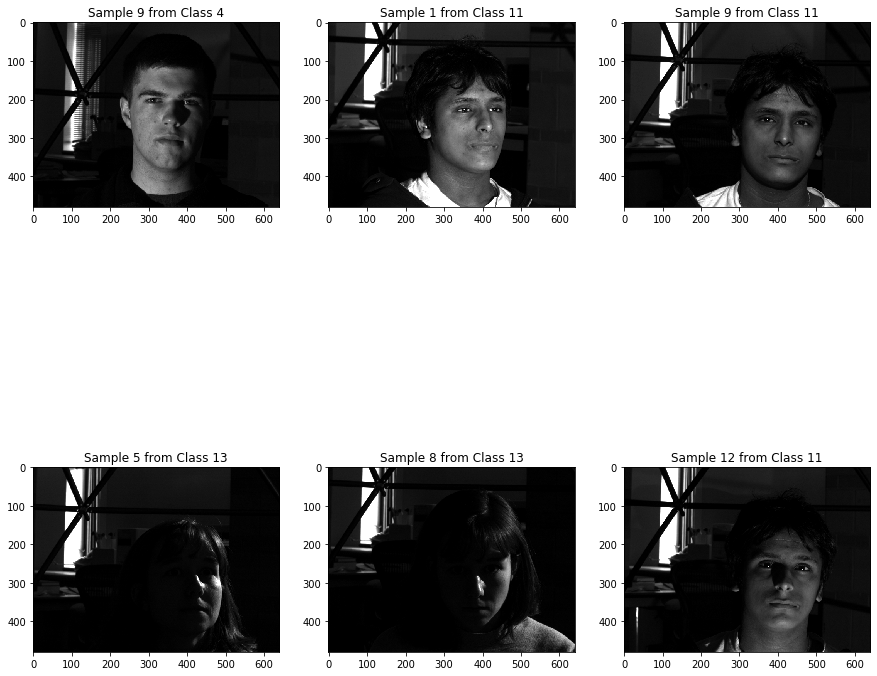

In [49]:
plt.rcParams['figure.figsize'] = [15, 15]

for i in range(6):
    # Pick random class and sample
    idx = np.random.choice(np.arange(num_train))
    cls = np.random.choice(np.arange(num_classes))
    im = np.reshape(trainData[cls, idx, :], (img_height, img_width))
    
    # Plot
    plt.subplot(str(230+i+1))
    plt.imshow(im, cmap='gray')
    plt.title('Sample %i from Class %i' % (idx, cls))

# Fisherfaces implementation

In [50]:
# Get image averages within each class
avg = np.average(trainData, axis=1)

# Get total average image
avg_tot = np.average(avg, axis=0)

# Helper function for SVD
def pca(m):
    _, d, vh = np.linalg.svd(m, full_matrices=False)
    V = vh.transpose()
    return d, V

# Subtract class averages from samples
k = trainData - np.reshape(avg, (num_classes, 1, img_size))
k = np.reshape(k, (num_classes * num_train, img_size))

# Subtract total average from class averages
m = avg - avg_tot

# Take SVD of k and invert eigenvalues
d, v = pca(k)
vw = np.matmul(v, np.diag(np.power(d, -1)))

# Use for m, take SVD
m_prime = np.matmul(m, vw)
_, vb = pca(m_prime)

# Find final V
V = np.matmul(vw, vb)

## Test performance without distortions

In [51]:
# Form training data for KNN using V matrix
x_train = np.matmul(np.reshape(trainData, (num_classes * num_train, img_size)), V)
y_train = trainClass

# Form testing data for KNN using V matrix
x_test = np.matmul(np.reshape(testData, (num_classes * num_test, img_size)), V)
y_test = testClass

# Create KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(x_train, y_train)

y_pred  = knn.predict(x_test)
success = np.sum(y_pred == y_test)

print('Model successfully predicted %i out of %i test faces, or %0.1f%%' %
      (success, num_classes * num_test, 100 * success / (num_classes * num_test)))

Model successfully predicted 222 out of 225 test faces, or 98.7%


## Add distortions to dataset

In [52]:
# Function to apply a homography to an image from Natalia's problem set 2 submission

def applyH(Iin, H):
    h, w = Iin.shape[0], Iin.shape[1]
    
    corners = np.concatenate([np.array([[0.],[0.],[1.]]), 
                              np.array([[0.],[h - 1.],[1.]]), 
                              np.array([[w - 1.], [0.],[1.]]), 
                              np.array([[w - 1.], [h - 1.],[1.]])], axis=1)
    newcorners = np.dot(H, corners)
    xmin, xmax = np.amin(newcorners[0]/newcorners[2]), np.amax(newcorners[0]/newcorners[2])
    ymin, ymax = np.amin(newcorners[1]/newcorners[2]), np.amax(newcorners[1]/newcorners[2])
    
    # set resuolution
    num_x_points = w
    num_y_points = h
    
    # Create regularly-spaced grid of (x,y)-pixel coordinates
    # corresponding to the outpput image
    x, y = np.meshgrid(np.linspace(xmin, xmax, num_x_points), np.linspace(ymin, ymax, num_y_points))

    # Reshape them and stack so that a homography can be applied to all points in parallel
    X = np.stack([x.flatten(), y.flatten()])
    
    # Get inverse images of this regular grid under H
    xh = np.linalg.lstsq(H, np.concatenate([X, [np.ones(len(X[0]))]]))[0]
    Xh = xh[:2] / xh[2]

    # Get interpolator 
    interpolator = scipy.interpolate.RegularGridInterpolator((np.arange(num_y_points), np.arange(num_x_points)), 
                                                             Iin, bounds_error=False, 
                                                             fill_value=Iin.min())

    # Interpolate I to get intensity values at image points Xh.
    # the interpolator is defined using (y,x)-pixel coordinates so we need to swap x and y in Xh
    # We also need to transpose Xh to be a list [[x1, y1], [x2, y2], ...] instead of
    # [[x1,x2,...],[y1,y2,...]]
    Iout = interpolator(np.transpose(np.array([Xh[1], Xh[0]])))
    
    # Reshape intensity vector into image with correct height and width
    Iout = np.reshape(Iout, (num_y_points, num_x_points))

    # Points in Xh that are outside the boundaries of the image are assigned
    # value np.nan, which means 'not a number'. The final step is to
    # set the intensities at these points to zero.
    # (Another possible solution is defining fill_value=0 in scipy.interpolate.RegularGridInterpolator.)
    #Iout[Iout == np.nan] = 0
                      
    return Iout

Text(0.5, 1.0, 'Sample Distorted and Translated')

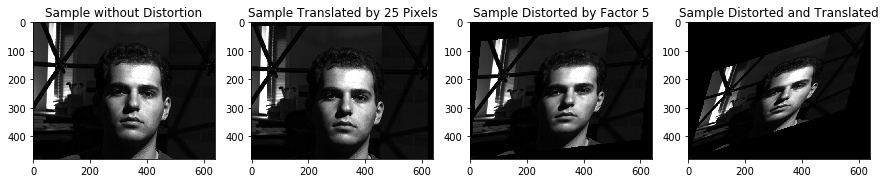

In [59]:
plt.rcParams['figure.figsize'] = [5, 5]

# Generate random translation within distance pixscale
def genTranslation(pixscale):
    dx = random.uniform(-1,1) * pixscale
    dy = random.uniform(-1,1) * np.sqrt(pixscale**2 - dx**2)
    return int(dx), int(dy)
    
# Genreate random affine transformation such that the principal values
# are within (1/p, p)
def genAffinity(p):
    scale = np.diag([random.uniform(1 / p, p), random.uniform(1 / p, p)])
    theta = random.uniform(0, 2 * np.pi)
    s, c = np.sin(theta), np.cos(theta)
    A = np.matmul(np.array([[c, s],[-s, c]]), np.matmul(scale, np.array([[c, -s],[s, c]])))
    return A

# Generate homography matrix from shift and rotation
def genHom(r, t):
    h = np.eye(3)
    # Add rotation and translation
    h[:2, :2] = r
    h[0, 2] = t[0]
    h[1, 2] = t[1]
    return h

# Shift matrix along given axis by amount, zero padding as necessary
def shift(matrix, amount, ax):
    a = np.roll(matrix, amount, axis = ax).swapaxes(0, ax)
    if amount > 0:
        a[:amount] = 0 
    elif amount < 0:
        a[amount:] = 0
    return a.swapaxes(0, ax)

# Visualize effect of distortions using random sample
plt.rcParams['figure.figsize'] = [15, 15]

cls = np.random.choice(np.arange(num_classes))
idx = np.random.choice(np.arange(num_train))
im = np.reshape(trainData[cls, idx, :], (img_height, img_width))
    
plt.figure()
plt.subplot("141")
plt.imshow(im, cmap='gray')
plt.title('Sample without Distortion')

plt.subplot("142")
amx, amy = genTranslation(25)
sim = shift(im, amy, 0)
sim = shift(sim, amx, 1)
plt.imshow(sim, cmap='gray')
plt.title('Sample Translated by 25 Pixels')

plt.subplot("143")
H = genHom(genAffinity(5), genTranslation(0))
plt.imshow(applyH(im, H), cmap='gray')
plt.title('Sample Distorted by Factor 5')

plt.subplot("144")
H = genHom(genAffinity(5), genTranslation(25))
plt.imshow(applyH(im, H), cmap='gray')
plt.title('Sample Distorted and Translated')

## Test accuracy with translations

Text(0, 0.5, 'Percentage Correctly Classified Samples')

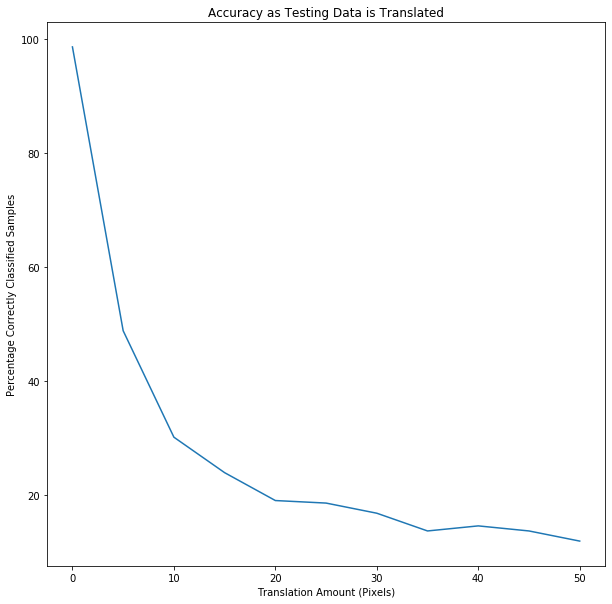

In [60]:
# Define translation amounts
thresh = np.linspace(0, 50, 11)
acc = np.array([])

# Find accuracy for each translation amount
for dt in thresh:
    # Apply translation to each image in test set
    x_test = np.reshape(testData, (num_classes * num_test, img_height, img_width))
    
    for i in range(num_classes * num_test):
        dx, dy = genTranslation(dt)
        x_test[i, :, :] = shift(x_test[i, :, :], int(dx), 1)
        x_test[i, :, :] = shift(x_test[i, :, :], int(dy), 0)

    # Apply V matrix and predict using previously trained KNN
    x_test = np.matmul(np.reshape(x_test, (num_classes * num_test, img_size)), V)
    y_pred = knn.predict(x_test)
    success = np.sum(y_pred == y_test)
    
    acc = np.append(acc, success / (num_classes * num_test))

# Create graph of final results
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure()
plt.plot(thresh, np.multiply(acc, 100))
plt.title('Accuracy as Testing Data is Translated')
plt.xlabel('Translation Amount (Pixels)')
plt.ylabel('Percentage Correctly Classified Samples')

## Test accuracy with distortions

Text(0, 0.5, 'Percentage Correctly Classified Samples')

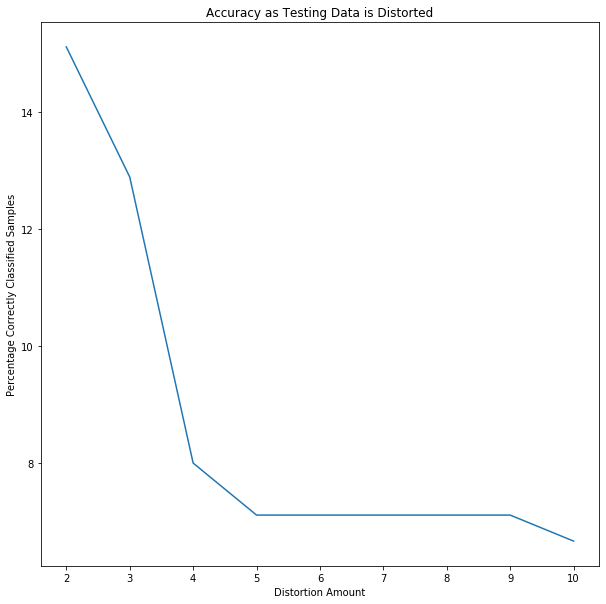

In [62]:
# Define distortion amounts
dist = np.linspace(2, 10, 9)
acc = np.array([])

# Find accuracy for each translation amount
for d in dist:
    # Apply translation to each image in test set
    x_test = np.reshape(testData, (num_classes * num_test, img_height, img_width))
    
    for i in range(num_classes * num_test):
        H = genHom(genAffinity(d), genTranslation(0))
        x_test[i, :, :] = applyH(x_test[i, :, :], H)

    # Apply V matrix and predict using previously trained KNN
    x_test = np.matmul(np.reshape(x_test, (num_classes * num_test, img_size)), V)
    y_pred = knn.predict(x_test)
    success = np.sum(y_pred == y_test)
    
    acc = np.append(acc, success / (num_classes * num_test))

# Create graph of final results
plt.figure()
plt.plot(dist, np.multiply(acc, 100))
plt.title('Accuracy as Testing Data is Distorted')
plt.xlabel('Distortion Amount')
plt.ylabel('Percentage Correctly Classified Samples')

## Test accuracy with distortions and rotations

Text(0, 0.5, 'Percentage Correctly Classified Samples')

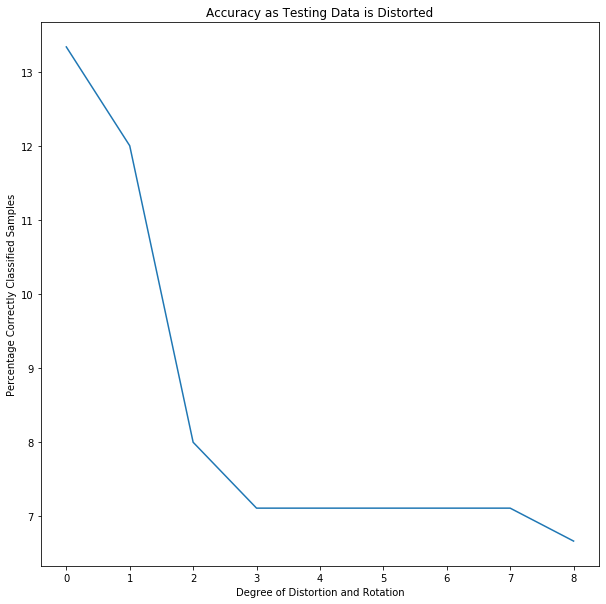

In [64]:
# Define distortion amounts
rot = np.linspace(10, 50, 9)
dist = np.linspace(2, 10, 9)
acc = np.array([])

# Find accuracy for each translation amount
for i in range(9):
    # Apply translation to each image in test set
    x_test = np.reshape(testData, (num_classes * num_test, img_height, img_width))
    
    for j in range(num_classes * num_test):
        H = genHom(genAffinity(dist[i]), genTranslation(rot[i]))
        x_test[j, :, :] = applyH(x_test[j, :, :], H)

    # Apply V matrix and predict using previously trained KNN
    x_test = np.matmul(np.reshape(x_test, (num_classes * num_test, img_size)), V)
    y_pred = knn.predict(x_test)
    success = np.sum(y_pred == y_test)
    
    acc = np.append(acc, success / (num_classes * num_test))

# Create graph of final results
plt.figure()
plt.plot(np.arange(9), np.multiply(acc, 100))
plt.title('Accuracy as Testing Data is Distorted')
plt.xlabel('Degree of Distortion and Rotation')
plt.ylabel('Percentage Correctly Classified Samples')